# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide.` Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

#### Download datasets

In [1]:
# create data folder
!mkdir data

# download, unzip and move the dog's dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip
!mv dogImages.zip ./data/dogImages.zip
!mv dogImages/ ./data/dogImages/

# download,unzip and move humans dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip -q lfw.zip
!mv lfw.zip ./data/lfw.zip
!mv lfw ./data/lfw
!rm -rf ./__MACOSX/

In [2]:
# in case of a new environment
!pip install numpy pytorch torchvision matplotlib opencv-python Pillow

#### Define all imports

In [3]:
# define all imports
import os
import time
import datetime
import math
import random
from glob import glob

import matplotlib.pyplot as plt
import cv2                
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
# Set PIL to be tolerant of image files that are truncated.
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

#### Global definitions - Few definitions used through out this notebook

In [4]:
# define the directories
data_dir = 'data/dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# define device where it will run (cuda or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device supported", device)

Device supported cuda


#### Load files from dataset directories and print the total

In [5]:
# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob(data_dir + "/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


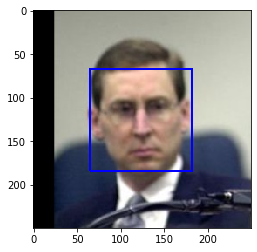

In [6]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [8]:
total_files = 100
human_files_short = human_files[:total_files]
dog_files_short = dog_files[:total_files]

#-#-# Do NOT modify the code above this line. #-#-#

faces_count_human_files = 0
faces_count_dog_files = 0

for i in range(total_files):
    faces_count_human_files += face_detector(human_files_short[i])
    faces_count_dog_files += face_detector(dog_files_short[i])

print("Using OpenCV with haarcascades")
print("{:.2f}% faces found on human files".format(faces_count_human_files/total_files *100))
print("{:.2f}% faces found on dogs files".format(faces_count_dog_files/total_files *100))

Using OpenCV with haarcascades
98.00% faces found on human files
8.00% faces found on dogs files


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True).to(device)

# define InceptionV3 model
InceptionV3 = models.inception_v3(pretrained=True).to(device)
InceptionV3 = InceptionV3.eval()

# define resnet50 model
ResNet50 = models.resnet50(pretrained=True).to(device)
ResNet50 = ResNet50.eval()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

**Helper Function** - Convert a file image into array/tensor for PyTorch

In [10]:
def file_image_to_tensor(img_path, min_img_size):
    '''
    Used to load and convert the image to Tensor
    Args: 
        img_path: path to an image
        min_img_size: the min size, as noted in the PyTorch
    Returns:
        Tensor object
    '''
    # load the image
    image = Image.open(img_path)
    
    # resize, normalize and transform into tensor
    # https://pytorch.org/docs/master/torchvision/models.html
    # https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
    transform_pipeline = transforms.Compose([
        transforms.Resize(min_img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    # preprocessing using a transform pipeline.
    image = transform_pipeline(image)
    
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
    image = image.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.     
    # set device to process in (cuda if gpu available otherwie, cpu)
    return image.to(device)

**Helper functions** - Prediction methods using different pretraied models

In [11]:
# predictor for VGG-16 model
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    Args:
        img_path: path to an image  
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image = file_image_to_tensor(img_path, 224)
    # predict
    prediction = VGG16(Variable(image))
    # get the max index
    class_index = prediction.detach().cpu().numpy().argmax()
    return class_index # predicted class index


# predictor for Inception-V3 model
def InceptionV3_predict(img_path):
    '''
    Use pre-trained Inception V3 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    Args:
        img_path: path to an image  
    Returns:
        Index corresponding to InceptionV3 model's prediction
    '''
    image = file_image_to_tensor(img_path, 299)
    # predict
    prediction = InceptionV3(Variable(image))
    # get the max index
    class_index = prediction.detach().cpu().numpy().argmax()
    return class_index # predicted class index


# predictor for ResNet-50 model
def ResNet50_predict(img_path):
    '''
    Use pre-trained ResNet-50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path    
    Args:
        img_path: path to an image
    Returns:
        Index corresponding to InceptionV3 model's prediction
    '''
    image = file_image_to_tensor(img_path, 224)
    # predict
    prediction = ResNet50(Variable(image))
    # get the max index
    class_index = prediction.detach().cpu().numpy().argmax()
    return class_index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, predictor):
    '''
    Identify if the input image has a dog on it
    Args:
        img_path: path to the image to be analyzed
        predictor: predictor method which will be used
    Returns:
        Boolean: True in the image provided has a dog on it, otherwise, False
    '''
    class_index = predictor(img_path)
    return 151 <= class_index <= 268  # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
Please check the answer on the cells bellow. It was tested using VGG16, Inception-V3 and ResNet50.

**Helper function** - assess_model will assess the model accuracy of dogs and humans found on the dataset

In [13]:
# Test the performance of the dog_detector function
# on the images in human_files_short and dog_files_short.
def assess_model(model_name, predictor):
    '''
    Assess the model performance and printout the results
    Args:
        model: pre-trained model to be tested
        model_name: the name of this model
    '''
    dogs_count_human_files = 0
    dogs_count_dog_files = 0

    for i in range(total_files):
        dogs_count_human_files += dog_detector(human_files_short[i], predictor)
        dogs_count_dog_files += dog_detector(dog_files_short[i], predictor)
    
    print("Testing {}".format(model_name))
    print("{:.2f}% dogs found on human files".format(dogs_count_human_files/total_files *100))
    print("{:.2f}% dogs found on dogs files".format(dogs_count_dog_files/total_files *100))

In [14]:
assess_model('VGG16', VGG16_predict)

Testing VGG16
1.00% dogs found on human files
99.00% dogs found on dogs files


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

**Optional** - Assessing accuracy of Inception V3 and ResNet-50 models

In [15]:
# assessing Inception V3 pretrained model
assess_model('Inception V3', InceptionV3_predict)

Testing Inception V3
2.00% dogs found on human files
99.00% dogs found on dogs files


In [16]:
# assessing ResNet-50 pretrained model 
assess_model('ResNet-50', ResNet50_predict)

Testing ResNet-50
0.00% dogs found on human files
100.00% dogs found on dogs files


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

**Helper function** - Load images directory, augment and transform to data loader

In [17]:
def dir_to_data_loader(data_dir, transform, aug_transform, batch_size=20, num_workers=0, use_augmentation=True):
    '''
    Load data from diretory, apply transforms and concat datasets (original + augmented)
    Args:
        data_dir: directory from here it will loa the images
        transform: transforms to apply while loading the data directory
        aug_transform: transforms to apply over the augmented data
        batch_size: how many samples per batch to load
        num_workers: how many subprocesses to use for data loading        
    Return:
        concact data loader (original + augmented)
    '''
    # load images from directory into dataset
    dataset = None
    original_dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    dataset = original_dataset
    if use_augmentation:
        augmented_dataset = datasets.ImageFolder(data_dir, transform=aug_transform)
        dataset = ConcatDataset([original_dataset, augmented_dataset])
    
    # create the data loader with concated dataset
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers)
    
    # printout the dataset quantity
    print("\tDirectory {:30s} {} (original) -> {} (final)".format(data_dir, len(original_dataset), len(dataloader.dataset)))
    return dataloader, original_dataset.classes

In [18]:
# define parameters for transforms
def get_dataloaders(min_size_image, use_augmentation=True, normalize_input=True):
    print("Creating dataloeaders, augmentation: {}, normalize: {}".format(use_augmentation, normalize_input))
    
    # normalizer needed for pre-trained models
    normalization_mean = (0.485, 0.456, 0.406)
    normalization_std = (0.229, 0.224, 0.225)

    default_transform_list = [
        transforms.Resize((min_size_image,min_size_image)),
        transforms.ToTensor()
    ]
    
    data_aug_transforms_list = [
        transforms.Resize((min_size_image,min_size_image)),
        transforms.RandomAffine((0, 180), translate=(0.1, 0.3), scale=(0.9, 1.3)),
        transforms.ColorJitter(contrast=(0.5, 1.0), saturation=(0.6, 1.0)),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(0.003, 0.02), ratio=(0.3, 3.3)),
        transforms.RandomErasing(scale=(0.001, 0.01), ratio=(0.2, 2.3))
    ]
    
    if normalize_input:
        normalize_transform = transforms.Normalize(normalization_mean, normalization_std)
        default_transform_list.append(normalize_transform)
        data_aug_transforms_list.append(normalize_transform)
        
    # define transformation to apply over the datasets
    default_transforms = transforms.Compose(default_transform_list)

    # define transforms for data augmentation
    data_aug_transforms = transforms.Compose(data_aug_transforms_list)

    # prepare data loaders
    train_loader, train_targets = dir_to_data_loader(train_dir, default_transforms, data_aug_transforms, use_augmentation=use_augmentation)
    valid_loader, _ = dir_to_data_loader(valid_dir, default_transforms, data_aug_transforms, use_augmentation=use_augmentation)
    test_loader, _ = dir_to_data_loader(test_dir, default_transforms, data_aug_transforms, use_augmentation=use_augmentation)
    
    return train_loader, valid_loader, test_loader, train_targets

In [19]:
train_loader, valid_loader, test_loader, targets = get_dataloaders(112, use_augmentation=True, normalize_input=False)

Creating dataloeaders, augmentation: True, normalize: False
	Directory data/dogImages/train/          6680 (original) -> 13360 (final)
	Directory data/dogImages/valid/          835 (original) -> 1670 (final)
	Directory data/dogImages/test/           836 (original) -> 1672 (final)


#### Visualize some sample data

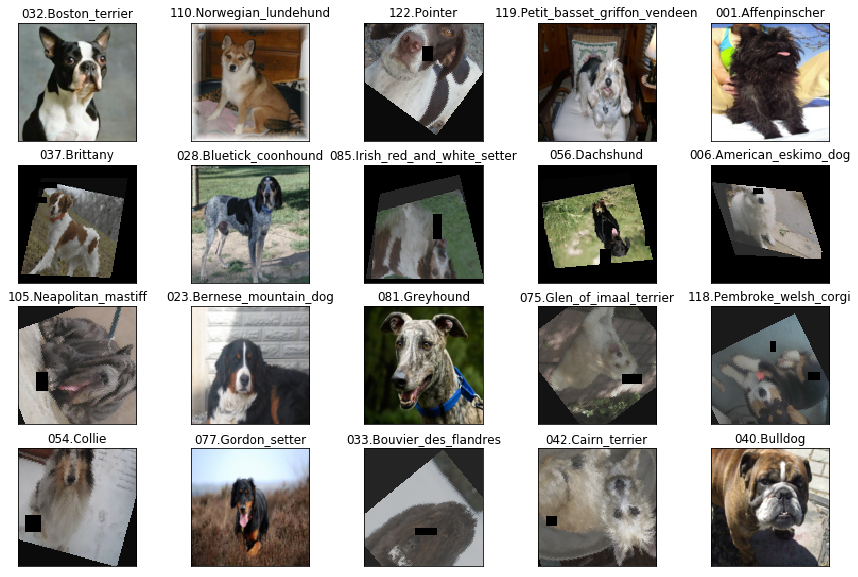

In [20]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15,10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(targets[labels[idx].numpy()])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: For the preprocessing it just uses the `transforms.Resize` to keep the consistent size of 112x112. It shows up in the data visualization, that using the `Crop` feature to resize the imageas didn't result well, in lots of images resulted into images without the face of the dog, which would contribute to lower the score.

I decided to use the input tensor of 112, which is the half the input used on vgg16, resnet. I tried to use input as those models (224x224) but the accuracty didn't improve and it took much more time to train.

I ran some benchmarks and training the CNN using augmented data helped the accuracty of this model. It was applied a few transformations, like Translation, Perspective distortion, Color Jitter, Erasing pixels area.
Data augmentation helped in doubling my data set for training, considering Deep Neural Networks usually needs a lot of data to learn, this was a good feature to implement.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [21]:
# define the CNN architecture

# VGG16 architecture from https://github.com/pytorch/vision/blob/d9a3018fb7b312f471cbe856a7bbe36076574d37/torchvision/models/vgg.py#L63
class NetVGG16(nn.Module):
    def __init__(self, num_classes=133, init_weights=False):
        super(NetVGG16, self).__init__()
        self.features = self._make_features()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def _make_features(self):
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)


# Cifar10 CNN architecture from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 
class NetCifar10(nn.Module):
    def __init__(self, num_classes=133):
        super(NetCifar10, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)    
        self.fc1 = nn.Linear(64 * 8 * 8, 500)
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 8 * 8)  
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x
    
    
# Simple CNN from https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch
class NetSimple(torch.nn.Module):
    def __init__(self, num_classes=133):
        super(NetSimple, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = torch.nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = torch.nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = torch.nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = torch.nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = torch.nn.Conv2d(256, 512, 3, padding=1)
        self.conv10 = torch.nn.Conv2d(512, 512, 3, padding=1)
        self.conv11 = torch.nn.Conv2d(512, 1024, 3, padding=1)
        self.conv12 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(1024 * 7 * 7, 2048)
        self.fc2 = torch.nn.Linear(2048, 1024)
        self.fc3 = torch.nn.Linear(1024, 512)
        self.fc4 = torch.nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        # 56 -> 28
        x = self.pool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        # 28 -> 14
        x = self.pool(F.relu(self.conv9(x)))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        # 14 -> 7
        x = self.pool(F.relu(self.conv12(x)))
        x = torch.flatten(x, 1)
        # Linear layer needs to be 1024 (channels) * 7 (height) * 7 (width)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [22]:
# instantiate the main CNN 
model_scratch = NetVGG16().to(device)

# instanciate the NetSimple CNN for comparison
model_scratch_simple = NetSimple().to(device)

# instanciate the NetCifar10 CNN for comparison
model_scratch_cifar10 = NetCifar10().to(device)

In [23]:
# weight initialization
def weights_init_normal(m):
    '''
    Takes in a module and initializes all linear layers with weight
    values taken from a normal distribution.
    '''    
    if isinstance(m, nn.Linear):
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))

In [24]:
# Applying weight initialization into all models
model_scratch = model_scratch.apply(weights_init_normal)
model_scratch_cifar10 = model_scratch_cifar10.apply(weights_init_normal)
model_scratch_simple = model_scratch_simple.apply(weights_init_normal)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ Create a new CNN architecture needs a lot of effort, understand the math behind and testing it can be hard. Especially on DNN, which consumes lots of data, computing power and time to run. Considering the background I have and learned from the Nanodegree, I believe I couldn't come which anything that good to reach 10% accuracy

I decided to find a simple CNN to give a trial run and see how the model plus data behaves. Sadly it turned out the outcome was quiet back, reaching just 1-2% of accuracy.

After a few consideration, I decided to pick a few well-known architectures, like Cifar10 and VGG16 and I try to train a model from scratch using those. After some tries, data and hyperparameters tuning, I could reach the best accuracy of 20% using the VGG10. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [25]:
# VGG16
# defined loss function
criterion_scratch = nn.CrossEntropyLoss()
# defined optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

# CIFAR-10
# defined loss function
criterion_scratch_cifar10 = nn.CrossEntropyLoss()
# defined optimizer
optimizer_scratch_cifar10 = optim.SGD(model_scratch_cifar10.parameters(), lr=0.001, momentum=0.9)

# Simple
# defined loss function
criterion_scratch_simple = nn.CrossEntropyLoss()
# defined optimizer
optimizer_scratch_simple = optim.SGD(model_scratch_simple.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [26]:
def train(n_epochs, stop_epochs, train_loader, valid_loader, model, optimizer, criterion, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    train_loss_hist = []
    valid_loss_hist = []
    
    # controls for how many epochs no improvement was done
    epochs_without_improvement = 0
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        epoch_start = time.time()

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).to(device)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()            
            # update running training loss
            train_loss += loss.item() * data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).to(device)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += loss.item() * data.size(0)
            
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        train_loss_hist.append(train_loss)
        valid_loss_hist.append(valid_loss)
        
        # print training/validation statistics 
        print('Epoch:{}\n\tDuration: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            str(datetime.timedelta(seconds= time.time() - epoch_start)),
            train_loss,
            valid_loss
            ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        # break the loop if no improvement has happened
        if epochs_without_improvement >= stop_epochs:
            break
            
    # return trained model
    return model, train_loss_hist, valid_loss_hist

**Helper function** - Trigger the training and tracks the total training time

In [27]:
def execute_training(model, save_path, train_loader, valid_loader, optimizer, criterion, 
                     epochs_number=100, stop_epochs=6):
    '''
    This wraps around the timer to count how long the training/validation takes
    Args:
        model: model which will be used for training
        save_path: file path where the model should be saved
        train_loader: data loader used for training
        valid_loader: data loader used for validation
        optimizer: optimizer used for training
        criterion: criterion used for training and validation
        epochs_number: max number of epochs the CNN will train
        stop_epochs: number of consecutives epochs without improvement before halt the training
    Return:
        trained model
    '''
    # it will save the moment the training starts 
    start_training = time.time()
    print("\nStart training of {}: {}".format(model.__class__.__name__, datetime.datetime.now()))
        
    # train and get the current best model instance
    model = train(epochs_number, stop_epochs, 
                  train_loader, valid_loader, 
                  model, optimizer, criterion, save_path)

    # it will save the last moment whent the train stops
    end_training = time.time()

    # print out the total time the train took to finished
    print("Total time for training", str(datetime.timedelta(seconds=end_training-start_training)))
    return model

**Helper function** - Plot graph with Train vs Validation loss

In [28]:
# Plot history Training vs Validation
def show_train_valid_loss(model_name, train_hist, valid_hist):
    '''
    Plot graph from the train and validation loss history
    Args:
        model_name: name of the model to show on the graph
        train_hist: train loss history
        valid_hist: validation loss history
    '''
    num_epochs = len(train_hist)

    plt.title("{} - Loss vs Number of Training Epochs".format(model_name))
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1, num_epochs+1), train_hist, label="Training")
    plt.plot(range(1, num_epochs+1), valid_hist, label="Validation")
    # plt.ylim((0,6.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    
    fig_size = plt.gcf().get_size_inches() # Get current size
    sizefactor = 2 # Set a zoom factor
    # Modify the current size by the factor
    plt.gcf().set_size_inches(sizefactor * fig_size) 

    plt.show()

#### Training the VGG16 net architecture

In [29]:
train_loader, valid_loader, test_loader, targets = get_dataloaders(112, use_augmentation=True, normalize_input=True)

# execute training for VGG16 net
result_pack = execute_training(model_scratch, 'model_scratch.pt', 
                               train_loader, valid_loader, 
                               optimizer_scratch, criterion_scratch)

# unpack result
model_scratch, train_loss, valid_loss = result_pack

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Creating dataloeaders, augmentation: True, normalize: True
	Directory data/dogImages/train/          6680 (original) -> 13360 (final)
	Directory data/dogImages/valid/          835 (original) -> 1670 (final)
	Directory data/dogImages/test/           836 (original) -> 1672 (final)

Start training of NetVGG16: 2020-02-07 13:52:27.130479
Epoch:1
	Duration: 0:03:43.768963 	Training Loss: 4.885181 	Validation Loss: 4.868843
	Validation loss decreased (inf --> 4.868843).  Saving model ...
Epoch:2
	Duration: 0:03:36.350634 	Training Loss: 4.873649 	Validation Loss: 4.864524
	Validation loss decreased (4.868843 --> 4.864524).  Saving model ...
Epoch:3
	Duration: 0:03:41.978866 	Training Loss: 4.866068 	Validation Loss: 4.859379
	Validation loss decreased (4.864524 --> 4.859379).  Saving model ...
Epoch:4
	Duration: 0:03:35.988144 	Training Loss: 4.858155 	Validation Loss: 4.852978
	Validation loss decreased (4.859379 --> 4.852978).  Saving model ...
Epoch:5
	Duration: 0:03:36.195357 	Training L

<All keys matched successfully>

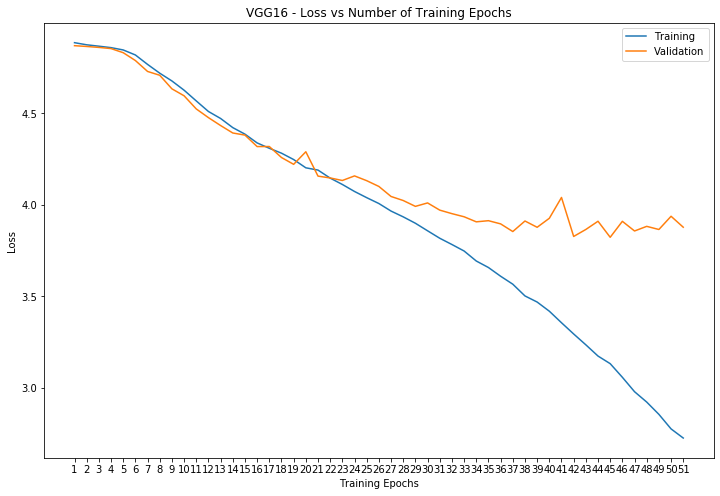

In [30]:
# Plot Train vs Validation Loss
show_train_valid_loss("VGG16", train_loss, valid_loss)

#### Training the Simple net architecture

In [31]:
train_loader, valid_loader, test_loader, targets = get_dataloaders(112, use_augmentation=True, normalize_input=True)

# execute training for Simple net
result_pack = execute_training(model_scratch_simple, 'model_scratch_simple.pt', 
                               train_loader, valid_loader, 
                               optimizer_scratch_simple, criterion_scratch_simple)

# unpack result
model_scratch_simple, train_loss_simple, valid_loss_simple = result_pack

# load the model that got the best validation accuracy
model_scratch_simple.load_state_dict(torch.load('model_scratch_simple.pt'))

Creating dataloeaders, augmentation: True, normalize: True
	Directory data/dogImages/train/          6680 (original) -> 13360 (final)
	Directory data/dogImages/valid/          835 (original) -> 1670 (final)
	Directory data/dogImages/test/           836 (original) -> 1672 (final)

Start training of NetSimple: 2020-02-07 16:58:09.419901
Epoch:1
	Duration: 0:03:54.335700 	Training Loss: 4.885303 	Validation Loss: 4.873435
	Validation loss decreased (inf --> 4.873435).  Saving model ...
Epoch:2
	Duration: 0:03:55.228024 	Training Loss: 4.867693 	Validation Loss: 4.859962
	Validation loss decreased (4.873435 --> 4.859962).  Saving model ...
Epoch:3
	Duration: 0:03:55.691688 	Training Loss: 4.832916 	Validation Loss: 4.794066
	Validation loss decreased (4.859962 --> 4.794066).  Saving model ...
Epoch:4
	Duration: 0:03:58.202516 	Training Loss: 4.762740 	Validation Loss: 4.735229
	Validation loss decreased (4.794066 --> 4.735229).  Saving model ...
Epoch:5
	Duration: 0:03:54.450063 	Training 

<All keys matched successfully>

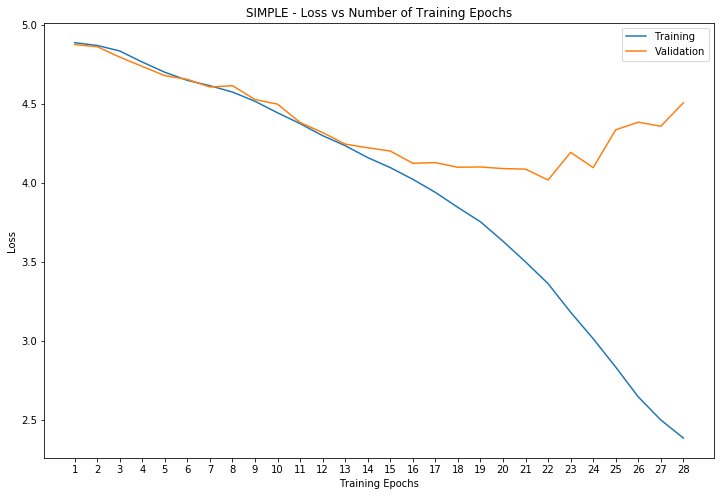

In [32]:
# Plot Train vs Validation Loss
show_train_valid_loss("SIMPLE", train_loss_simple, valid_loss_simple)

#### Training the Cifar10 net architecture

In [33]:
# load dataloader informing the new image size
train_loader_cifar10, valid_loader_cifar10, test_loader_cifar10, _ = get_dataloaders(64) # 128

# execute training for CIFAR10 net
result_pack = execute_training(model_scratch_cifar10, 'model_scratch_cifar10.pt', 
                               train_loader_cifar10, valid_loader_cifar10, 
                               optimizer_scratch_cifar10, criterion_scratch_cifar10)

# unpack result
model_scratch_cifar10, train_loss_cifar10, valid_loss_cifar10 = result_pack

# load the model that got the best validation accuracy
model_scratch_cifar10.load_state_dict(torch.load('model_scratch_cifar10.pt'))

Creating dataloeaders, augmentation: True, normalize: True
	Directory data/dogImages/train/          6680 (original) -> 13360 (final)
	Directory data/dogImages/valid/          835 (original) -> 1670 (final)
	Directory data/dogImages/test/           836 (original) -> 1672 (final)

Start training of NetCifar10: 2020-02-07 18:48:35.529074
Epoch:1
	Duration: 0:02:07.963183 	Training Loss: 4.873341 	Validation Loss: 4.829087
	Validation loss decreased (inf --> 4.829087).  Saving model ...
Epoch:2
	Duration: 0:02:08.986436 	Training Loss: 4.765206 	Validation Loss: 4.710857
	Validation loss decreased (4.829087 --> 4.710857).  Saving model ...
Epoch:3
	Duration: 0:02:08.079587 	Training Loss: 4.642029 	Validation Loss: 4.597442
	Validation loss decreased (4.710857 --> 4.597442).  Saving model ...
Epoch:4
	Duration: 0:02:07.975684 	Training Loss: 4.532084 	Validation Loss: 4.534570
	Validation loss decreased (4.597442 --> 4.534570).  Saving model ...
Epoch:5
	Duration: 0:02:07.850330 	Training

<All keys matched successfully>

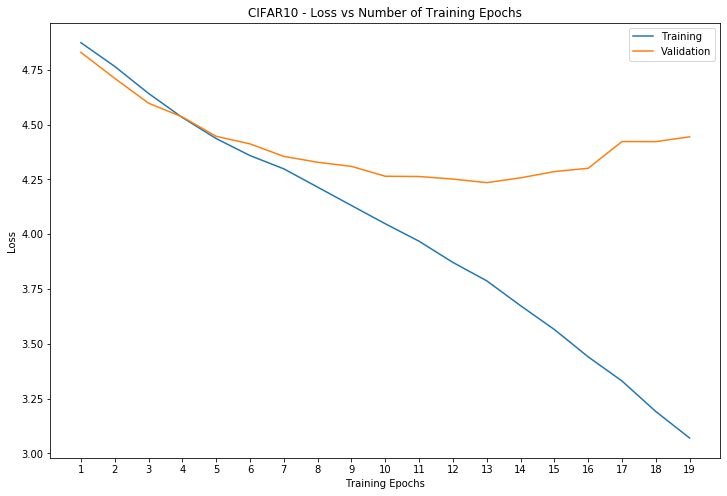

In [34]:
# Plot Train vs Validation Loss
show_train_valid_loss("CIFAR10", train_loss_cifar10, valid_loss_cifar10)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [35]:
def test(test_loader, model, criterion):
    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):        
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    
    total_samples = len(test_loader.dataset)
    test_loss = test_loss/total_samples            
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (100.0*correct/total_samples, correct, total_samples))

#### Test model VGG16

In [36]:
test(test_loader, model_scratch, criterion_scratch)

Test Loss: 3.783790
Test Accuracy: 12% (210/1672)


Benchmark from VGG16 model

|Optim|Lr|Augmentation|Input|Input Normal|Loss|Accuracy|Time|
|-----|--|----------|-----|------------|----|    ---:|---:|
|SGD|0.001|Yes|112|Yes|3.421716|21% (359/1672)|1:47:01|
|SGD|0.001|Yes|224|Yes|3.675206|17% (287/1672)|7:53:44|
|SGD|0.003|No|112|Yes|3.671078|13% (111/836)|1:17:23|
|SGD|0.01|No|112|No|4.856271|1% (10/836)|17:58|
|SGD|0.01|No|224|No|4.856173|1% (10/836)|57:54|


#### Test model Simple

In [37]:
test(test_loader, model_scratch_simple, criterion_scratch)

Test Loss: 4.029687
Test Accuracy: 10% (173/1672)


Benchmark from Simple model

|Optim|Lr|Augmentation|Input|Input Normal|Loss|Accuracy|Time|
|-----|--|----------|-----|------------|----|    ---:|---:|
|SGD|0.001|Yes|112|Yes|3.994852|10% (169/1672)|1:45:16|
|SGD|0.001|No|112|No|4.086393|15% (129/836)|13:42|
|SGD|0.001|Yes|112|No|4.029544|11% (197/1672)|24:02|
|SGD|0.001|No|112|Yes|3.996213|9% (76/836)|39:20|

#### Test model CIFAR10

In [38]:
test(test_loader_cifar10, model_scratch_cifar10, criterion_scratch)

Test Loss: 4.282423
Test Accuracy:  7% (126/1672)


Benchmark from CIFAR10 model

|Optim|Lr|Augmentation|Input|Input Normal|Loss|Accuracy|Time|
|-----|--|----------|-----|------------|----|    ---:|---:|
|SGD|0.001|Yes|128|Yes|4.290435|6% (109/1672)|27:53|
|SGD|0.001|No|128|No|4.225436|7% (64/836)|17:23|
|SGD|0.001|Yes|128|No|4.360651|5% (98/1672)|46:34|
|SGD|0.001|No|128|Yes|4.255437|7% (63/836)|11:05|
|SGD|0.001|Yes|256|Yes|4.194411|8% (74/836)|14:26|
|SGD|0.001|Yes|64|Yes|4.156563|8% (67/836)|13:56|

### Plot the Training and Validation Loss from all NN

In [39]:
def plot_models_loss(train_losses, valid_losses):
    epochs = 0
    # find the greatest epoch
    for loss in train_losses:
        loss_size = train_losses[loss]
        if len(loss_size) > epochs:
            epochs = len(loss_size) 
    
    plt.title("Training Loss vs Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")

    for loss in train_losses:
        plt.plot(range(1, len(train_losses[loss])+1), train_losses[loss], label=loss)
    
    plt.xticks(np.arange(1, epochs+1, 1.0))
    plt.legend()
    
    fig_size = plt.gcf().get_size_inches() # Get current size
    sizefactor = 2 # Set a zoom factor
    # Modify the current size by the factor
    plt.gcf().set_size_inches(sizefactor * fig_size)
    
    plt.show()

    plt.title("Validation Loss vs Number of Training Epochs")
    plt.xlabel("Validation Epochs")
    plt.ylabel("Loss")
    
    for loss in valid_losses:
        plt.plot(range(1, len(valid_losses[loss])+1), valid_losses[loss], label=loss)

    plt.xticks(np.arange(1, epochs+1, 1.0))
    plt.legend()
    
    fig_size = plt.gcf().get_size_inches() # Get current size
    sizefactor = 2 # Set a zoom factor
    # Modify the current size by the factor
    plt.gcf().set_size_inches(sizefactor * fig_size)
    
    plt.show()

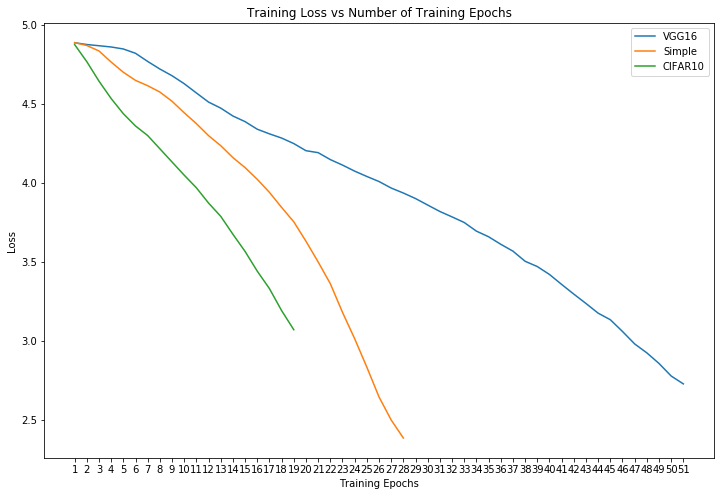

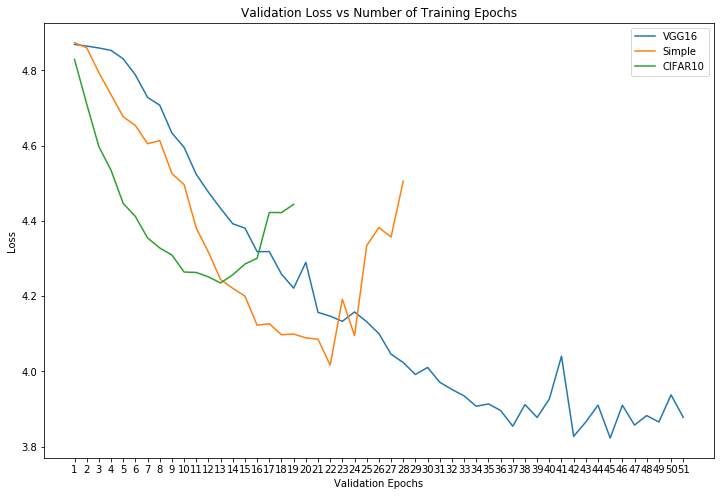

In [40]:
train_loss_list = {"VGG16": train_loss, "Simple": train_loss_simple, "CIFAR10": train_loss_cifar10}
valid_loss_list = {"VGG16": valid_loss, "Simple": valid_loss_simple, "CIFAR10": valid_loss_cifar10}
plot_models_loss(train_loss_list, valid_loss_list)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [41]:
# define parameters for transforms
# pre-trained vgg16-19 and other need a 224px image as input
min_size_image = 224 

# for transfer learning, DO NOT GENERATE AUGMENTATION
train_loader, valid_loader, test_loader, targets = get_dataloaders(min_size_image, 
                                                                   use_augmentation=False, 
                                                                   normalize_input=True)

Creating dataloeaders, augmentation: False, normalize: True
	Directory data/dogImages/train/          6680 (original) -> 6680 (final)
	Directory data/dogImages/valid/          835 (original) -> 835 (final)
	Directory data/dogImages/test/           836 (original) -> 836 (final)


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [42]:
# Load the pretrained model from pytorch
model_transfer = models.vgg19(pretrained=True)

# get the number of classes to set on the output layer
num_classes = len(targets)

# freeze training for all layers
for param in model_transfer.parameters():
    param.requires_grad = False
    
# add a last linear layer  that maps n_inputs -> 133
# new layers automatically have requires_grad = True
n_inputs = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(in_features=n_inputs, out_features=num_classes)

# set model to evalulation
model_transfer.eval()

# set device to run in
model_transfer = model_transfer.to(device)
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
I started testing the VGG16 which was one of the first exercises on this notebook, there we learn that we need to freeze all layers to avoid any update because those already learned to identify many features. Afterward, I just updated the last layer to define the new classes, which in this case was the 133 different dog's breed which we want to classify.

As an extra exercise, I tried many different models to check which one would fulfill the needs of this project. In a few of them, the names of the last layer changes, but printing out the model made it easy to understand and apply the update on the classifier layer.

Almost all the vgg*, densenet121, and resnet50 could achieve 85% of accuracy and quiet fast. I would choose the vgg16 as go-to for testing any new problem because it reached 85% accuracy with an average of 20 min of training (with Cuda support). But In this project I'll give a tray on the vgg19, even though it took around double the time from vgg16, it reaches 1% more accuracy, a total of 86% accuracy. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [43]:
# define loss function
criterion_transfer = nn.CrossEntropyLoss()

# define optimizer
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [44]:
# define the dataloaders without augmentation data
train_loader, valid_loader, test_loader, targets = get_dataloaders(224, use_augmentation=False, normalize_input=True)

# start the training process
result_pack = execute_training(model_transfer, 'model_transfer.pt', 
                               train_loader, valid_loader,
                               optimizer_transfer, criterion_transfer)

# unpack result
model_transfer, train_loss_transfer, valid_loss_transfer = result_pack

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Creating dataloeaders, augmentation: False, normalize: True
	Directory data/dogImages/train/          6680 (original) -> 6680 (final)
	Directory data/dogImages/valid/          835 (original) -> 835 (final)
	Directory data/dogImages/test/           836 (original) -> 836 (final)

Start training of VGG: 2020-02-07 19:30:48.178882
Epoch:1
	Duration: 0:02:13.333353 	Training Loss: 1.765486 	Validation Loss: 0.758472
	Validation loss decreased (inf --> 0.758472).  Saving model ...
Epoch:2
	Duration: 0:02:07.683529 	Training Loss: 0.659620 	Validation Loss: 0.568331
	Validation loss decreased (0.758472 --> 0.568331).  Saving model ...
Epoch:3
	Duration: 0:02:01.886802 	Training Loss: 0.524432 	Validation Loss: 0.511048
	Validation loss decreased (0.568331 --> 0.511048).  Saving model ...
Epoch:4
	Duration: 0:02:02.185308 	Training Loss: 0.444133 	Validation Loss: 0.474987
	Validation loss decreased (0.511048 --> 0.474987).  Saving model ...
Epoch:5
	Duration: 0:02:02.455190 	Training Loss: 0.

<All keys matched successfully>

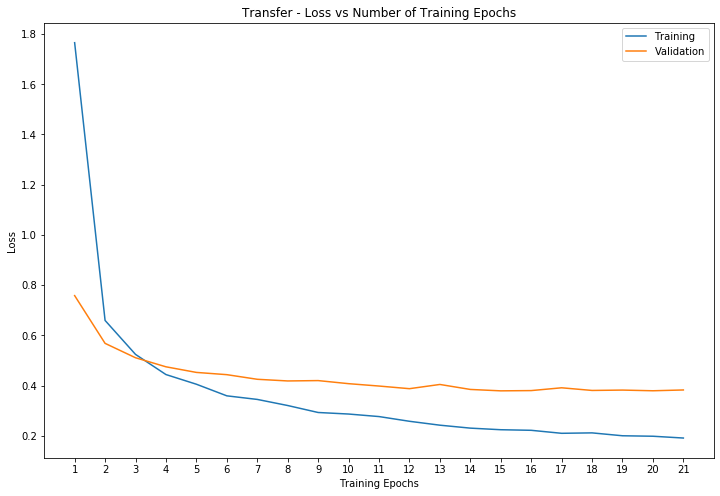

In [45]:
# Plot Train vs Validation Loss
show_train_valid_loss("Transfer", train_loss_transfer, valid_loss_transfer)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [46]:
test(test_loader, model_transfer, criterion_transfer)

Test Loss: 0.411718
Test Accuracy: 88% (736/836)


Benchmark from a few other models

|Model|Optim|Lr|Augmentation|Input|Input Normal|Loss|Accuracy|Time|
|-----|-----|--|----------|-----|------------|----|    ---:|---:|
|vgg16|SGD|0.001|No|224|Yes|0.544376|85% (712/836)|19:25|
|vgg16|SGD|0.001|No|112|Yes|1.190016|70% (593/836)|18:18|
|vgg16|SGD|0.001|Yes|112|Yes|2.213305|47% (788/1672)|1:05:58|
|vgg16|SGD|0.001|Yes|224|Yes|1.284714|67% (1124/1672)|1:28:01|
|vgg16_bn|SGD|0.001|No|224|Yes|0.476989|84% (709/836)|31:38|
|vgg19|SGD|0.001|No|224|Yes|0.517820|86% (727/836)|43:48|
|vgg19_bn|SGD|0.001|No|224|Yes|0.442478|85% (716/836)|28:23|
|densenet121|SGD|0.001|No|224|Yes|0.504897|85% (714/836)|1:19:14|
|Resnet50|SGD|0.001|No|224|Yes|0.447121|86% (723/836)|1:39:18|

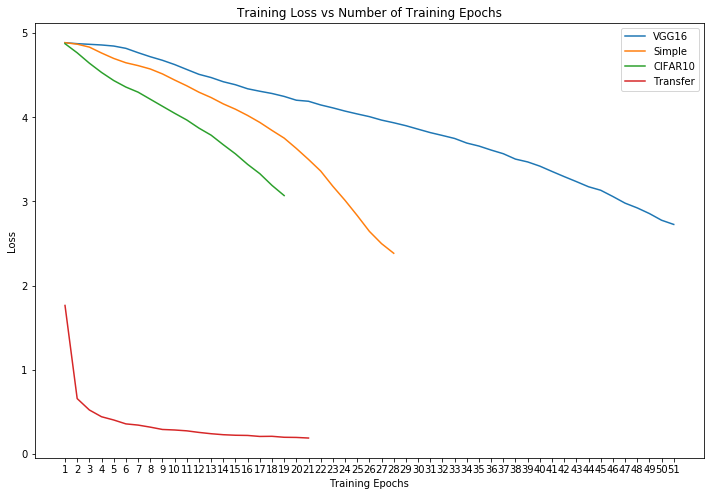

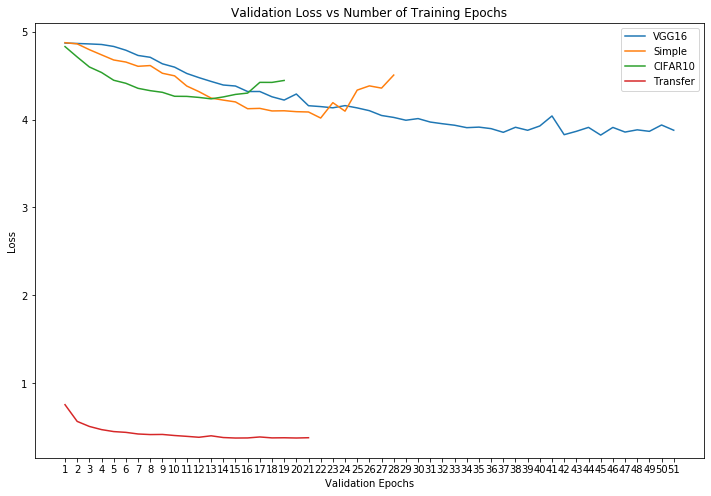

In [47]:
# define map with all models and train/valid loss history
train_loss_list = {"VGG16": train_loss, "Simple": train_loss_simple, "CIFAR10": train_loss_cifar10, "Transfer": train_loss_transfer}
valid_loss_list = {"VGG16": valid_loss, "Simple": valid_loss_simple, "CIFAR10": valid_loss_cifar10, "Transfer": valid_loss_transfer}

# plot all models trained/validated until now 
plot_models_loss(train_loss_list, valid_loss_list)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [48]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in targets]

def predict_breed_transfer(img_path):
    '''
    Predicts the dog's breed based on the image file input
    Args:
        img_path: path to the image to be analysed
    Return:
        the dog's breed
    '''
    # load the image and return the predicted breed
    image = file_image_to_tensor(img_path, min_size_image)
    # predict
    prediction = model_transfer(Variable(image))
    # get the max index
    class_index = prediction.detach().cpu().numpy().argmax()
    return class_names[class_index]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [49]:
from enum import Enum
class Type(Enum):
    NONE = 0
    DOG = 1
    HUMAN = 2
    
def run_app(img_path):
    '''
    It identifies if the image filehas a dog, human face or neither.
    In case of dog, it will classify into one of 133 breeds available on the model.
    In case of a human face, it will output the most close dog's breed which the human looks like.
    Args:
        img_path: image input file which will be analysed
    Return:
        It results 2 values: 
        predicted: enum type: NONE, DOG or HUMAN
        dogs_breed: has the dog's breed
    '''
    ## handle cases for a human face, dog, and neither
    predicted = Type.NONE
    
    # verify with DL if has a dog on the image
    if dog_detector(img_path, ResNet50_predict):
        predicted = Type.DOG
    
    # if DL didnt identify a dog, it tries to identify a human face using OpenCV
    if predicted == Type.NONE and face_detector(img_path):
        predicted = Type.HUMAN
        
    dogs_breed = None
    # if status is different than None, it tries to predict the breed
    if predicted != Type.NONE:
        # if it's a dog or human, then it checks for the breed
        dogs_breed = predict_breed_transfer(img_path)
        
    return predicted, dogs_breed

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.


__Answer:__ The result of the final algorithm looks good in my option, it shows up very stable and show the outcome with a good accuracy. 

Using the combination of 3 approaches:

- ResNet50 to identify dogs with 99% accuracy;  
- OpenCV haar cascade to identify human faces with 98% accuracy;
- This model using transfer learning from vgg19 with outcome of 85% to identify 133 dog's breed

This shows that offer the combination of multiple approaches help to improve the final result in a consumer application.

Still, few things can be done to improve the algoritm:
- to identify human's face using deep learning
- identify multiple dogs or multiple human faces
- identify dog's and human's at the same time in each picture
- define the boundary box in each dog's or human
- improve the model to get more accuracy

In [50]:
# printout the results from the classifier using a few images from each array
for file in np.hstack((human_files[:3], dog_files[:3])):
    predicted, dogs_breed = run_app(file)
    if predicted == Type.DOG:
        print("It's a dog and the breed is", dogs_breed)
    elif predicted == Type.HUMAN:
        print("It's a human being but it looks like a", dogs_breed)
    else:
        print("Neither dog nor human, sad")

It's a human being but it looks like a Dachshund
It's a human being but it looks like a Dachshund
It's a human being but it looks like a Dachshund
It's a dog and the breed is French bulldog
It's a dog and the breed is French bulldog
It's a dog and the breed is French bulldog


### Download new images which doesn't contain dogs or humans 

In [51]:
images_folders = ['data/arch', 'data/tech', 'data/nature'] 

arch_files = []
nature_files = []
tech_files = []

for folder in images_folders:
    # create folder into data folder if doesn't exists
    if not os.path.exists(folder):
        os.makedirs(folder)
    
# download 10 images from each category
for i in range(10):
    arch_files.append("./data/arch/arch-{}.jpg".format(i))
    nature_files.append("./data/nature/nature-{}.jpg".format(i))
    tech_files.append("./data/tech/tech-{}.jpg".format(i))
    os.system("wget http://placeimg.com/800/600/arch -O {}".format(arch_files[i]))
    os.system("wget http://placeimg.com/800/600/nature -O {}".format(nature_files[i]))
    os.system("wget http://placeimg.com/800/600/tech -O {}".format(tech_files[i]))

In [52]:
for file in np.hstack((arch_files[:3], dog_files[:3])):
    predicted, dogs_breed = run_app(file)
    if predicted == Type.DOG:
        print("It's a dog and the breed is", dogs_breed)
    elif predicted == Type.HUMAN:
        print("It's a human being but it looks like a", dogs_breed)
    else:
        print("Neither dog nor human, sad")

Neither dog nor human, sad
Neither dog nor human, sad
Neither dog nor human, sad
It's a dog and the breed is French bulldog
It's a dog and the breed is French bulldog
It's a dog and the breed is French bulldog


### Let's plot a few images using the algorithm

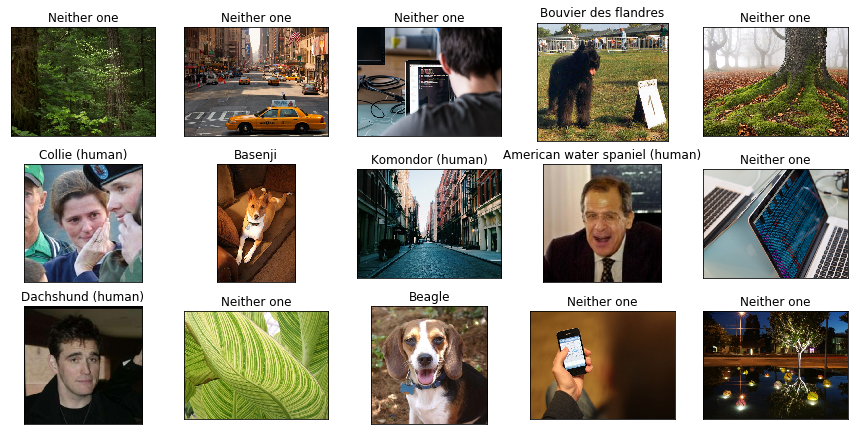

In [53]:
# pick 3 images from each array randomly
random_files = random.choices(human_files, k=3) + \
                random.choices(dog_files, k=3) + \
                random.choices(arch_files, k=3) + \
                random.choices(nature_files, k=3) + \
                random.choices(tech_files, k=3)
# shuffles the array
random.shuffle(random_files)

fig = plt.figure(figsize=(15,10))
for idx, file in enumerate(random_files):
    # run the model to identify dog's breed
    predicted, dogs_breed = run_app(file)

    # read the image from the file
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # plot the image
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(img)
    
    # add the legent based on the result
    if predicted == Type.DOG:
        ax.set_title(dogs_breed)
    elif predicted == Type.HUMAN:
        ax.set_title("{} (human)".format(dogs_breed))
    else:
        ax.set_title("Neither one")

### Run this cell a few times to get a random image with a message

In [59]:
def random_image_and_predict():
    file = random.choices(random_files)[0]
    predicted, dogs_breed = run_app(file)

    # read the image from the file
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    message = ""
    if predicted == Type.DOG:
         message = "Who is a good boy/girl?!?! Yes you are! You are a beautiful {breed}".format(breed=dogs_breed)
    elif predicted == Type.HUMAN:
        message = "Oh! Hello human being, this is a dog's breed classifer!\nBut looking at you again ... you really look like a {breed}".format(breed=dogs_breed)
    else:
        message = "Wait? It doesn't look like a dog or a human face, please, try again!"

    plt.title(message)
    plt.imshow(img)


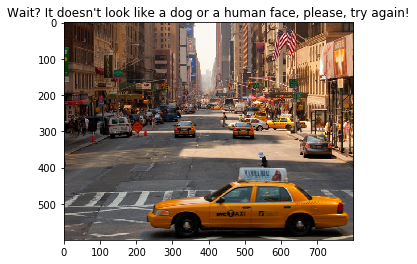

In [60]:
random_image_and_predict()

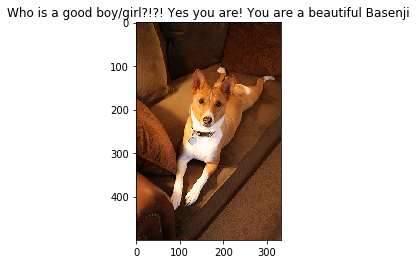

In [61]:
random_image_and_predict()

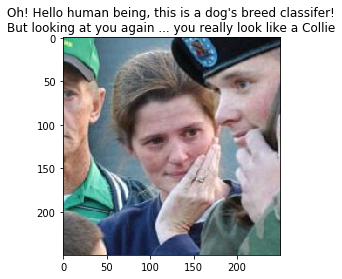

In [73]:
random_image_and_predict()